# Cirugía Haberman
***


## Master Universitario en Computación, Lógica e Inteligencia Artificial
## Aprendizaje Automático
***
### Ernesto Mancebo 

Ese dataset contiene casos de estudio conducidos entre 1958 y 1970 en la Hospital Universitario Billings de Chicago para pacientes sobreviviente a cirugía de cancer de mama.

Este dataset cuenta con 306 instancias, cada instancia con 4 atributos, de las cuales 3 son características y 1 es clasificatorio. Las características son: 
- age of patient (Edad del Paciente).
- axillary nodes detected (Nódulos Axilares Detectados).
- year of operation (Año de la Cirugía).

La columna clasificatoria tiene dos posibles valores:
- **1**: Sobrevivió más de 5 años.
- **2**: No sobrevivió más de 5 años.
***

En esta fase inicial, procedemos a importar todas las librerías a utilizar durante el estudio.

In [256]:
import math
import random

import matplotlib as mpl
import matplotlib.animation
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


 Pasamos a definir el nombre de las columnas en nuestro dataframe inicial, así como el nombre de la columna clasificatoria.

In [92]:
column_names = [
    "age_of_patient", "year_of_operation", "axillary_nodes_detected", "survival_status"
]
target_name = "survival_status"

df = pd.read_csv("haberman.data", names=column_names)

Estas funciones nos servirán de apoyo como sigue:

- `separar_dataframe`: Separar las columnas características de la clasificatoria a partir de un `dataframe`.
- `boxplot`: Imprimir un gráfico de caja o _box plot_ a partir de un `dataframe`.
- `pairplot`: Imprimir un scatter matrix (o _pairplot_ en la librería _seaborn_ ) a partir de un `dataframe`.

In [187]:
def separar_dataframe(dataframe):
    return (dataframe.iloc[:, -1], dataframe.iloc[:, :-1])


def boxplot(data, title=''):
    sns.boxplot(data=data, orient='h').set_title(title)


def pairplot(data, target, columns):
    sns.pairplot(data=data, hue=target, markers=["o", "D"], vars=columns)

Separamos el dataframe inicial `df`.

In [124]:
target_data, fields_data = separar_dataframe(df)

## Explorando la data

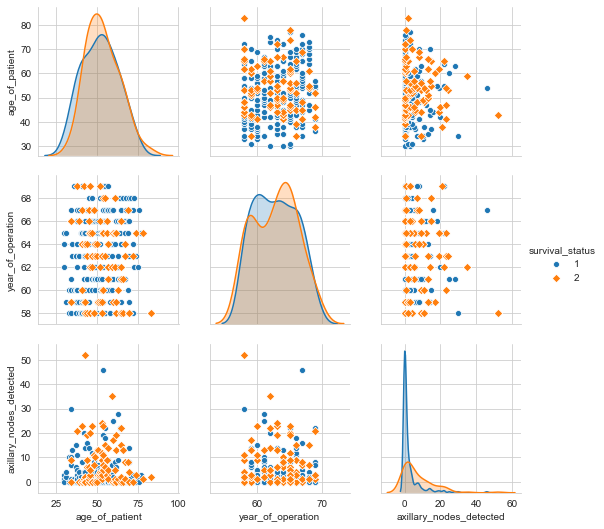

In [188]:
sns.set_style('whitegrid')
pairplot(df, target_name, column_names[:-1])

Podemos percibir a simple vista que la data para ambos grupos está mezclada, además de que existen valores alejados de la mayoría del conjunto.

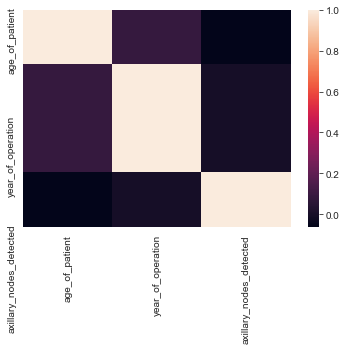

In [261]:
corr = df.iloc[:,:-1].corr()
sns.heatmap(corr)

Exploramos máx al detalle la data con boxplot a fin de identificar outliers

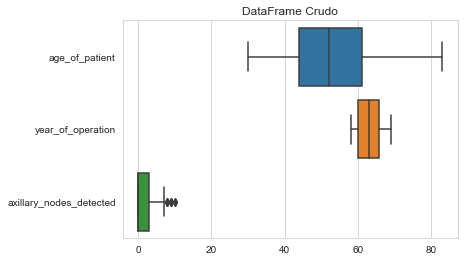

In [191]:
boxplot(fields_data, "DataFrame Crudo")

`axillary_nodes_detected` tiene instancias alejadas de su último percentil, sugiriéndonos verlo más a fondo haciéndole un boxplot por separado a la vez de visualizar la distribución de los valores.

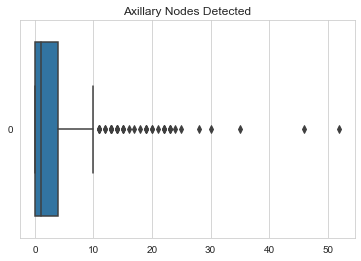

In [192]:
boxplot(df['axillary_nodes_detected'], "Axillary Nodes Detected")

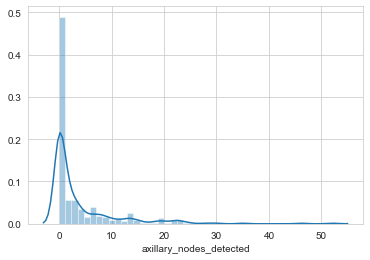

In [193]:
sns.distplot(df['axillary_nodes_detected'])

## Procesando Outliers

Sin discusión visualizamos la existencia de outliers, pero es preciso aplicar algunas funciones matemáticas a fin de conocer a ciencia cierta qué tanto ruido puede inducir en nuestro modelo.

### Trabajando con los primeros tres quartiles para el atributo `axillary_nodes_detected`

In [105]:
df['axillary_nodes_detected'].describe()

count    306.000000
mean       4.026144
std        7.189654
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       52.000000
Name: axillary_nodes_detected, dtype: float64

Tras la función `describe` para un dataframe de `pandas`, podemos visualizar que el 75% de los valores del dataset son para instancias cuyo valor en `axillary_nodes_detected` sean menor igual que 4; en ese sentido se procede a hacer una copia del dataframe crudo cuyo atributo bajo observación sea menor o igual que 4.

In [224]:
df_ol = df[df.axillary_nodes_detected <= 4]
df_ol.shape

(230, 4)

Actualmente contamos con 230 instancias de las 306 originales, procedemos a visualizar la distribución de la nueva data.

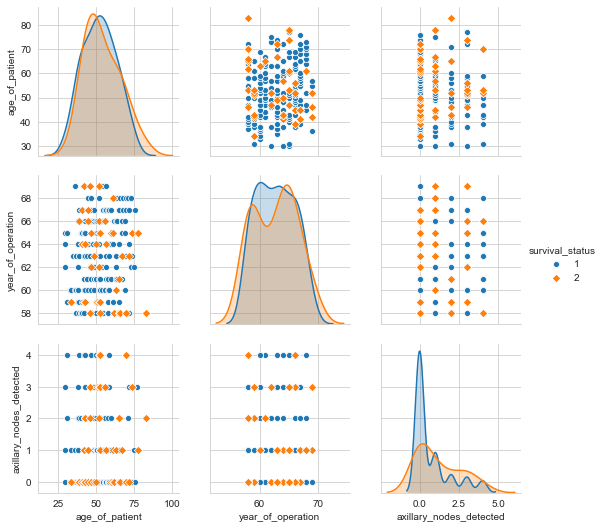

In [194]:
pairplot(df_ol, target_name, column_names[:-1])

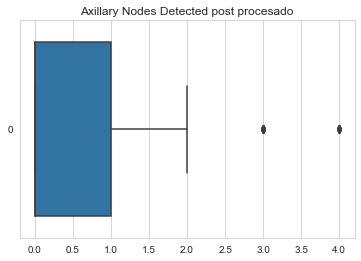

In [196]:
boxplot(df_ol['axillary_nodes_detected'],
        "Axillary Nodes Detected post procesado")

Contamos para el dataframe `df_ol` instancias con menos ruido para `axillary_node_detected`.

### Discriminando Outliers a partir de `Z-Score`

`Z-Score` es otra tecnica para tratar los outliers en la que busca un balance en la distribución de la data.

In [175]:
z_score = np.abs(stats.zscore(df))
print(z_score)

[[2.08214014 0.35358406 0.42159203 0.6       ]
 [2.08214014 0.26292148 0.14295885 0.6       ]
 [2.08214014 0.66183684 0.56090862 0.6       ]
 ...
 [2.2754471  0.66183684 0.14295885 0.6       ]
 [2.36816172 0.66183684 0.42159203 1.66666667]
 [2.83173483 1.49593258 0.28227544 1.66666667]]


Notamos que la puntuación para las instancias es de forma `0 < score < 2.5`, por lo que procedemos a elminar aquellas que excedan el mismo.

In [266]:
threshold = 2.5
print(np.where(z_score > threshold))

(array([  9,  43,  62,  96, 160, 168, 174, 188, 215, 227, 252, 254, 260,
       305], dtype=int64), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0], dtype=int64))


In [267]:
df_z = df[(z_score < threshold).all(axis=1)]
df_z.shape

(292, 4)

Contamos esta vez con 292 instancias, pero nos queda explorar qué tal queda la data.

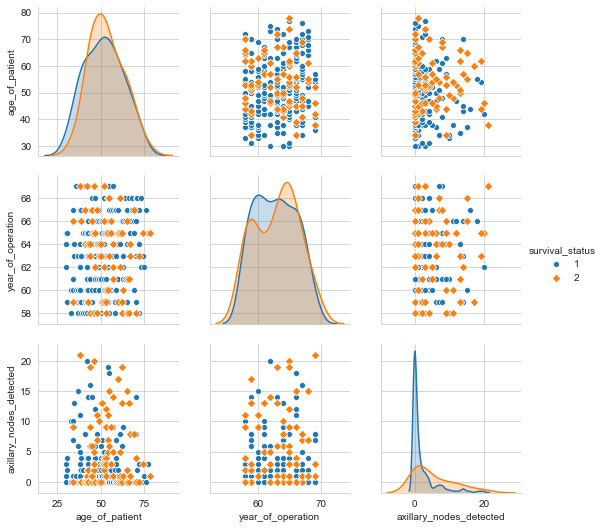

In [265]:
pairplot(df_z, target_name, column_names[:-1])

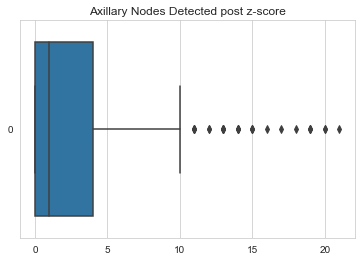

In [268]:
boxplot(df_z['axillary_nodes_detected'],
        "Axillary Nodes Detected post z-score")

Poseemos menos ruido para `axillary_nodes_detected`, pero la limpieza no fue tan significativa.

## Aplicando quartiles para el DataFrame completo

La tercera y última técnica a emplear para el manejo de outliers será similar a la primera, utilizaremos los primeros quartiles, pero para el dataset completo. Siendo más concreto, utilizaremos el `InterQuartile Range (IQR)`, consistente en la distribución media de la data entre el primer y tercer quartil.

In [179]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
print(iqr)

age_of_patient             16.75
year_of_operation           5.75
axillary_nodes_detected     4.00
survival_status             1.00
dtype: float64


In [184]:
df_qol = df[~((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).any(axis=1)]
df_qol.shape

(266, 4)

En esta ocasión quedamos con 266 instancias. Procedemos a visualizar.

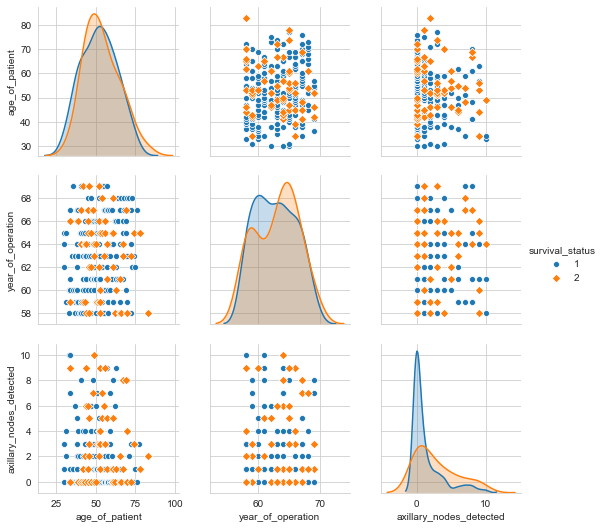

In [269]:
pairplot(df_qol, target_name, column_names[:-1])

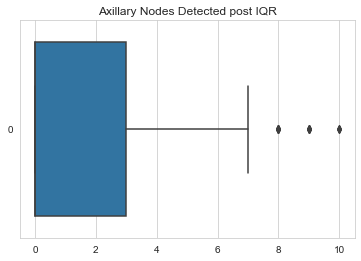

In [270]:
boxplot(df_qol['axillary_nodes_detected'],
        "Axillary Nodes Detected post IQR")

En esta ocasión notamos una mejora en la clasificación/reducción de outliers en comparación con `Z-Score`.

## Inicio del Entrenamiento

En esta fase realizaremos entrenamientos y pruebas con el conjunto de datos crudo a fin de comparar luego contra los distintos dataframes obtenidos tras eliminar los outliers del dataset original.

In [304]:
target_data, fields_data = separar_dataframe(df)

In [305]:
X_train, X_test, y_train, y_test = train_test_split(
    fields_data, target_data, stratify=target_data, train_size=0.10)

Las funciones `print_rendimiento` y `generar_modelo` nos servirán de apoyo para visualizar el rendimiento de los entrenamientos a partir de la configuración indicada en la segunda función.

In [277]:
def print_rendimiento(entrenamiento, prueba, total):
    print("Rendimiento en el conjunto de entrenamiento: ", entrenamiento)
    print("Rendimiento en el conjunto de prueba: ", prueba)
    print("Rendimiento en el conjunto total: ", total)


def generar_modelo(solver="lbfgs", f_activation="logistic", capas=(20,), aprendizaje=0.0001, batch="auto", max_iter=200):
    mlp_modelo = MLPClassifier(
        solver=solver, random_state=0, hidden_layer_sizes=capas, activation=f_activation, alpha=aprendizaje, batch_size=batch, max_iter=max_iter)
    mlp_modelo.fit(X_train, y_train)
    print_rendimiento(
        mlp_modelo.score(X_train, y_train),
        mlp_modelo.score(X_test, y_test),
        mlp_modelo.score(fields_data, target_data)
    )
    return mlp_modelo

La función `neuronas_capa_oculta` nos brinda una idea de cuántas neuronas debemos de inicialmente tener de aucerdo a la cantidad de neuronas de entrada y de salida.

In [278]:
def neuronas_capa_oculta(neuronas_entrada: int, neuronas_salida: int):
    return math.pow(neuronas_entrada * neuronas_salida, 1/2)

Se ha de tener presente que la cantidad de características para una instancia equivalen a la cantidad de neuronas de entrada, y que la cantidad de posibles valores de salida son la cantidad de neuronas de salida.

In [272]:
possibles_salidas = 2
# Se excluye la coluna clasificatoria
cantidad_de_atributos = len(column_names) -1
neuronas_ocultas = neuronas_capa_oculta(cantidad_de_atributos, possibles_salidas)
print(np.ceil(neuronas_ocultas))

3.0


Quedamos con 3 neuronas iniciales para las capas ocultas.

## Utilizando distinto Número de Capas y Neuronas

In [314]:
out = generar_modelo()

Rendimiento en el conjunto de entrenamiento:  0.8
Rendimiento en el conjunto de prueba:  0.7065217391304348
Rendimiento en el conjunto total:  0.7156862745098039


In [315]:
out = generar_modelo(capas=(3))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [316]:
out = generar_modelo(capas=(5))

Rendimiento en el conjunto de entrenamiento:  0.8333333333333334
Rendimiento en el conjunto de prueba:  0.5217391304347826
Rendimiento en el conjunto total:  0.5522875816993464


In [317]:
out = generar_modelo(capas=(10))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [318]:
out = generar_modelo(capas=(10,5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [319]:
out = generar_modelo(capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [320]:
out = generar_modelo(capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.8333333333333334
Rendimiento en el conjunto de prueba:  0.5217391304347826
Rendimiento en el conjunto total:  0.5522875816993464


In [321]:
out = generar_modelo(capas=(8,5))

Rendimiento en el conjunto de entrenamiento:  0.8333333333333334
Rendimiento en el conjunto de prueba:  0.677536231884058
Rendimiento en el conjunto total:  0.6928104575163399


Notamos que el rendimiento para los casos donde las capas internas son: `(10)`, `(10,5)`, `(5,5)`, es mayor y con un porcentaje de **`73.52%`**, mientras que para casos donde las capas son `(5)`, `(8,2)` y `(8, 5)`, es menor pues la capa segunda (o la única para el caso de `(5)`) posee pocas neuronas y tienen menos capacidad de aprendizaje tras cargarse de información con rendimiento **`69.28%`** o menor.

## Utilizando distinta Función de Activación

Utilizaremos las funciones: `identity`, `tanh` y `relu`. La función `logistic` es la por defecto en los casos previos. A la vez, utilizaremos el mejor de los casos y el peor de los casos con respecto a las capas en el caso anterior: `(5,5)` y `(8,2)`.

In [336]:
out = generar_modelo(f_activation="tanh", capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [337]:
out = generar_modelo(f_activation="tanh", capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.8
Rendimiento en el conjunto de prueba:  0.39492753623188404
Rendimiento en el conjunto total:  0.434640522875817


In [338]:
out = generar_modelo(f_activation="relu", capas=(5, 5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [344]:
out = generar_modelo(f_activation="relu", capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [341]:
out = generar_modelo(f_activation="identity", capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [340]:
out = generar_modelo(f_activation="identity", capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.8
Rendimiento en el conjunto de prueba:  0.6123188405797102
Rendimiento en el conjunto total:  0.630718954248366


Notamos que es consistente para los casos cuya configuración de capas es `(5,5)` y que sólamente incrementó con respecto al peor caso de capas `(8,2)` cuando la función de activación es `relu`.

## Utilizando distinto Optimizador de Capas

In [368]:
out = generar_modelo(solver="adam", capas=(8, 2), max_iter=5000)

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [366]:
out = generar_modelo(solver="adam", capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [364]:
out = generar_modelo(solver="sgd", capas=(8,2), max_iter=5000)

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [359]:
out = generar_modelo(solver="sgd", capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


En esta condición independientemente de los conjunto de datos el resultado es el mismo y un rendimiento no superior a los casos anteriores, pues por lo visto cada función de optimización de peso encuentra el punto _ideal_ con respecto al ajuste de peso para cada neurona, destacando que ambas funciones requieren más iteraciones (tiempo de procesado) para conseguir el peso idóneo cuando las capas son de forma `(8,2)`. Esto salió a relucir al momento de prueba tras conseguir una advertencia de tipo _ConvergenceWarning_.

## Utilizando distinto factor de aprendizaje y de tamaño de Batch

In [377]:
out = generar_modelo(aprendizaje=0.01,solver="sgd", capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [379]:
out = generar_modelo(aprendizaje=0.05,solver="sgd", capas=(8,2),max_iter=5000)

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [381]:
out = generar_modelo(aprendizaje=0.07, capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.9
Rendimiento en el conjunto de prueba:  0.5905797101449275
Rendimiento en el conjunto total:  0.6209150326797386


In [382]:
out = generar_modelo(aprendizaje=0.07, capas=(5, 5))

Rendimiento en el conjunto de entrenamiento:  0.8666666666666667
Rendimiento en el conjunto de prueba:  0.5978260869565217
Rendimiento en el conjunto total:  0.6241830065359477


In [383]:
out = generar_modelo(aprendizaje=0.01, capas=(8,2), batch=75)

Rendimiento en el conjunto de entrenamiento:  0.8333333333333334
Rendimiento en el conjunto de prueba:  0.5289855072463768
Rendimiento en el conjunto total:  0.5588235294117647


In [384]:
out = generar_modelo(aprendizaje=0.01, capas=(5,5), batch=100)

Rendimiento en el conjunto de entrenamiento:  0.8
Rendimiento en el conjunto de prueba:  0.605072463768116
Rendimiento en el conjunto total:  0.6241830065359477


In [385]:
out = generar_modelo(capas=(5,5), batch=100)

Rendimiento en el conjunto de entrenamiento:  0.7333333333333333
Rendimiento en el conjunto de prueba:  0.7355072463768116
Rendimiento en el conjunto total:  0.7352941176470589


In [386]:
out = generar_modelo(capas=(8,2), batch=50)

Rendimiento en el conjunto de entrenamiento:  0.8333333333333334
Rendimiento en el conjunto de prueba:  0.5217391304347826
Rendimiento en el conjunto total:  0.5522875816993464


Ya en esta última etapa tenemos una variedad de resultados. Tenemos que para los casos cuya velocidad de aprendizaje `0.01` y `0.05` es mucho mejor que cuando es más rápida con `0.07`, dejándo claro que el resultado no es mejor que los casos anteriores **`73.52%`**. A su vez Obtenemos mejores resultados cuando el batch de aprendizaje es en menor canitdad con respecto a mayor cantidad, pues nuestro conjunto de datos es muy pequeño, a penas `306` instancias, sin contar que se reduce cuando se separa el conjunto de prueba de el conjunto de aprendizaje.

## Entrenamiendo sin Outliers para `axillary_nodules_detected`

En esta sección y en la posterior haremos los estudios de lugar sólamente con las configuraciones más óptimas del apartado anterior.
***
Iniciamos generando y separando nuestro dataframe `df_ol` el cual es el correspondiente al conjunto de datos cuyos valores de `axillary_nodules_detected` son menores que `4`.

In [388]:
target_data, fields_data = separar_dataframe(df_ol)

In [389]:
X_train, X_test, y_train, y_test = train_test_split(fields_data, target_data, stratify=target_data)

In [395]:
out = generar_modelo(capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.8197674418604651
Rendimiento en el conjunto de prueba:  0.8103448275862069
Rendimiento en el conjunto total:  0.8173913043478261


In [398]:
out = generar_modelo(capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.8372093023255814
Rendimiento en el conjunto de prueba:  0.7931034482758621
Rendimiento en el conjunto total:  0.8260869565217391


In [400]:
out = generar_modelo(aprendizaje=0.01, capas=(8,2), batch=50)

Rendimiento en el conjunto de entrenamiento:  0.8197674418604651
Rendimiento en el conjunto de prueba:  0.8103448275862069
Rendimiento en el conjunto total:  0.8173913043478261


In [403]:
out = generar_modelo(solver="adam", capas=(8,2), f_activation="tanh", aprendizaje=0.01, max_iter=5000)

Rendimiento en el conjunto de entrenamiento:  0.8372093023255814
Rendimiento en el conjunto de prueba:  0.7931034482758621
Rendimiento en el conjunto total:  0.8260869565217391


In [404]:
out = generar_modelo(solver="adam", capas=(5,5), f_activation="tanh", aprendizaje=0.01, max_iter=5000)

Rendimiento en el conjunto de entrenamiento:  0.8197674418604651
Rendimiento en el conjunto de prueba:  0.8103448275862069
Rendimiento en el conjunto total:  0.8173913043478261


Sorprendentemente, notamos un incremento sustancial en el porcentaje de acertación llegando a un **`82.60%`**, incluso las configuraciones de capas `(8,2)` es mejor que `(5,5)` ¿qué pasó? Podemos concluir en que la reducción de ruido de los outliers permite a la `MLP` identificar con mayor precisión los casos positivos de negativos, y que el tener un criterio de pirámide (esto es capa `x1 > x2`) ayuda a distribuir mejor el peso para las neuronas.

## Entrenamiento sin Outliers de forma `IQR`
`

In [412]:
target_data, fields_data = separar_dataframe(df_qol)

In [406]:
X_train, X_test, y_train, y_test = train_test_split(fields_data, target_data, stratify=target_data)

In [409]:
out = generar_modelo(capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.7839195979899497
Rendimiento en el conjunto de prueba:  0.7761194029850746
Rendimiento en el conjunto total:  0.7819548872180451


In [410]:
out = generar_modelo(capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7889447236180904
Rendimiento en el conjunto de prueba:  0.7761194029850746
Rendimiento en el conjunto total:  0.7857142857142857


In [411]:
out = generar_modelo(solver="adam", capas=(8,2), f_activation="tanh", aprendizaje=0.01, max_iter=5000)

Rendimiento en el conjunto de entrenamiento:  0.7839195979899497
Rendimiento en el conjunto de prueba:  0.7761194029850746
Rendimiento en el conjunto total:  0.7819548872180451


Este método no nos ofrece mayor rendimiento con respecto al dataframe previo, pero sí un poco más con respecto al  original pues por la razón de que menor ruido nos ayuda a ser más preciso.

## Entrenamiendo sin Outliers a partir de `Z-Score`

In [415]:
target_data, fields_data = separar_dataframe(df_z)

In [416]:
X_train, X_test, y_train, y_test = train_test_split(fields_data, target_data, stratify=target_data)

In [417]:
out = generar_modelo(capas=(8,2))

Rendimiento en el conjunto de entrenamiento:  0.7899543378995434
Rendimiento en el conjunto de prueba:  0.7671232876712328
Rendimiento en el conjunto total:  0.7842465753424658


In [418]:
out = generar_modelo(capas=(5,5))

Rendimiento en el conjunto de entrenamiento:  0.7625570776255708
Rendimiento en el conjunto de prueba:  0.7671232876712328
Rendimiento en el conjunto total:  0.7636986301369864


In [419]:
out = generar_modelo(capas=(10))

Rendimiento en el conjunto de entrenamiento:  0.771689497716895
Rendimiento en el conjunto de prueba:  0.7671232876712328
Rendimiento en el conjunto total:  0.7705479452054794


In [420]:
out = generar_modelo(aprendizaje=0.01, capas=(8,5), batch=75)

Rendimiento en el conjunto de entrenamiento:  0.7899543378995434
Rendimiento en el conjunto de prueba:  0.7671232876712328
Rendimiento en el conjunto total:  0.7842465753424658


Este modelo generado a partir del dataframe `Z-Score` nos provee mejores resultados que el previo, cercanos al resultado obtenido tras discriminación por outliers ruidosos para `axillary_nodules_detected`.

## Conclusiones
---
Para el conjunto de datos bajo estudio hemos obtenido distintos resultados tras la consideración de distintas variables de configuración para el `MLP`, siendo el optimizador de capas o `solver` una de las propiedades más determinantes para este estudio, seguido de la velocidad de aprendizaje y la cantidad `batch` que en lo particular considero es impresindible rejugar con esta cuando se trata de datasets pequeños como este.

En ese mismo orden, a la hora de realizar estudios de conjuntos de datos es primordial graficar y explorar la data con la que nos hemos de enfrentar, pues puede darnos una idea de qué características pueden causarnos ruido y desplomar el rendimiento al momento de realizar una predicción, como así lo fue para este estudio.

Finalmente, es preciso considerar distintas técnicas para el tratamiento de outliers, pues no podemos abrazar una y definir que es la panacea ya que queda en evidencia que más de una técnia nos dió resultado similar, sin embargo trabajar con los primeros tres quartiles en `axillary_nodules_detected` nos arrojó el mejor resultado para todas las técnicas empleadas con un rendimiento de **`82.60%`**.

---

## Referencias
- [Ways to Detect and Remove the Outliers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)
- [Outlier Detection and Removal using Pandas Python](https://www.youtube.com/watch?v=2Qrost474lQ)
- [Redes Neuronales: numero de capas ocultas, hiperparametros en el perceptron](https://www.youtube.com/watch?v=Rip8wAaxAFg&t=146s)
- [Perceptron Redes Neuronales : capas ocultas, hiperparametros , neuronas por capa](https://www.youtube.com/watch?v=HKPE3mrxOPo&t=1153s)
- [The Ultimate Python Seaborn Tutorial: Gotta Catch ‘Em All](https://elitedatascience.com/python-seaborn-tutorial)
- [How to Configure the Number of Layers and Nodes in a Neural Network](https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/)